# 0. 0 - IMPORTS


In [19]:
import datetime

import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.gridspec   import GridSpec
from IPython.display       import Image

%matplotlib inline

## 0.1 Helper Functions

In [2]:
def cat_att_distribution(df, attribute, response, title, rot=False):
    
    aux1 = df[[attribute, response]].groupby(attribute).count().reset_index()
    
    if attribute == 'Complain':
        plt.bar(x=aux1['Complain'], height=aux1[response], tick_label=["No", 'Yes'], width=0.2, )
    else:
        plt.bar(x=aux1[attribute], height=aux1[response])
    
    plt.ylim([0, df.shape[0]])
    plt.axhline(y=333, linestyle='--', c='black');
    plt.title(title)
    if rot:
        plt.xticks(rotation=rot);

## 0.2 Loading Data

In [3]:
df_raw = pd.read_csv('ifood-data-business-analyst-test/ml_project1_data.csv', thousands=',', index_col='ID')

# copy df
df1 = df_raw.copy()

df1

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,43,...,5,0,0,0,0,0,0,3,11,0
4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,0,...,7,0,0,0,1,0,0,3,11,0
7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,48,...,6,0,1,0,0,0,0,3,11,0


# 1.0 - DATA DESCRIPTION

## 1.1 Data Dimensions      

In [4]:
proportion = 100*(df1['Response'][df1['Response']!=0].count()/df1.shape[0])

print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

print('Proportion of positive response: {:,.2f}%'.format(proportion))

Number of rows: 2240
Number of columns: 28
Proportion of positive response: 14.91%


## 1.2 Data Types

In [5]:
df1['Dt_Customer'] = pd.to_datetime(df1['Dt_Customer'])

df1.dtypes

Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Z_CostContact                   int64
Z_Revenue   

## 1.3 Check NA

Looking for null values, one can see that the column **Income** has 24 empty values.

In [6]:
df1.isna().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

Analyzing a bit deeper, it can be seen that most of these particular samples did not accepted the previous five offers nor responded well to the sixth. They also don't represent the profile of clients with high recency or high amounts of purchases. For that matter, **these empty values are going to be removed**.

Since the columns `Z_CostContact` and `Z_Revenue` just represent long arrays of unique values (3 for `Z_CostContact` and 11, for `Z_Revenue`), their variances equal zero and, therefore, they offer no value to the analysis and will be removed too.

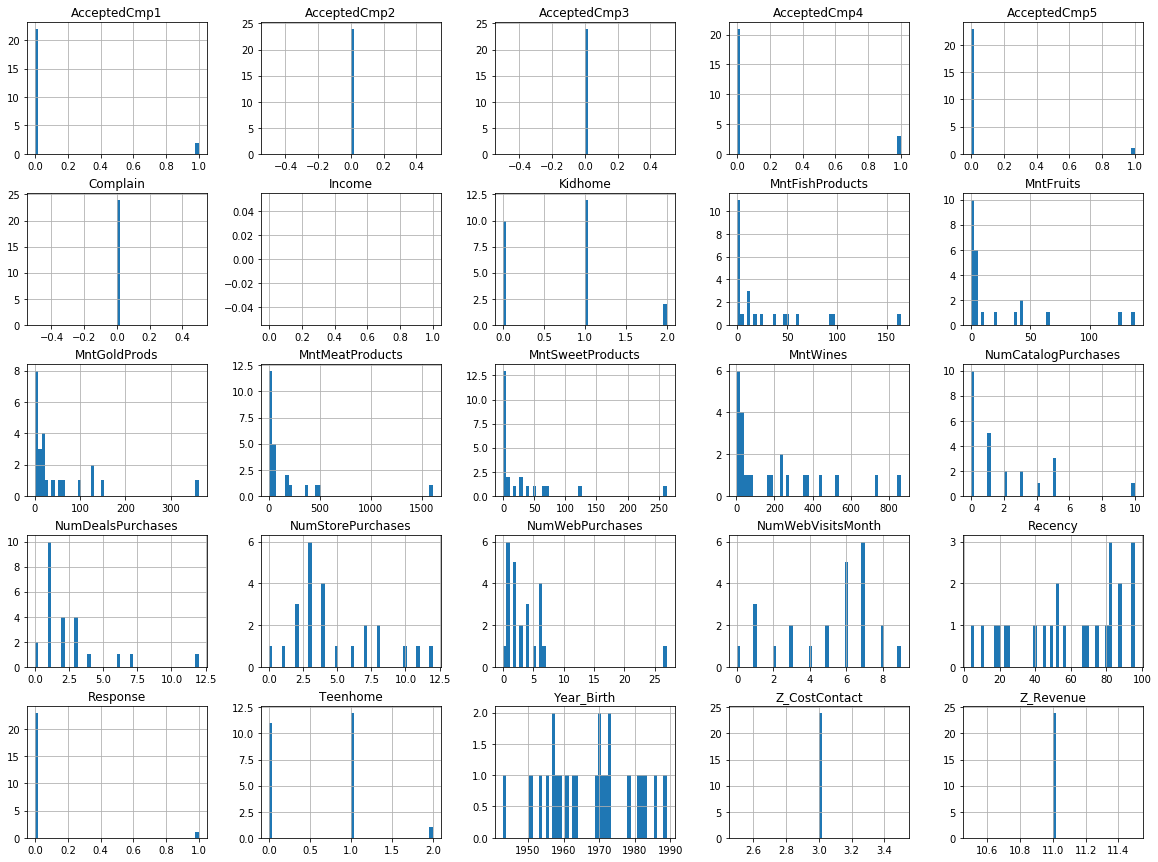

In [8]:
check_for_nan = df1[df1['Income'].isnull()]

#
check_for_nan.hist(bins=50, figsize = (20,15));

## 1.4 Dropping the empty values 

In [9]:
df1.dropna(axis = 0, how='any', inplace = True)

# Deleting Z_CostContact and Z_Revenue
print('Z_CostContact: {}\nZ_Revenue: {}'. format( str(df1['Z_CostContact'].unique()), str(df1['Z_Revenue'].unique() )))
del df1['Z_CostContact']
del df1['Z_Revenue']

df1.shape

Z_CostContact: [3]
Z_Revenue: [11]


(2216, 26)

## 1.5 Changing data types

In [10]:
cols_boolean = ['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response','Complain']
 
for i in cols_boolean:
    df1[cols_boolean] = df1[cols_boolean].apply(lambda x: x.astype(bool, copy=False), axis=1)

df1.dtypes

Year_Birth                      int64
Education                      object
Marital_Status                 object
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
MntWines                        int64
MntFruits                       int64
MntMeatProducts                 int64
MntFishProducts                 int64
MntSweetProducts                int64
MntGoldProds                    int64
NumDealsPurchases               int64
NumWebPurchases                 int64
NumCatalogPurchases             int64
NumStorePurchases               int64
NumWebVisitsMonth               int64
AcceptedCmp3                     bool
AcceptedCmp4                     bool
AcceptedCmp5                     bool
AcceptedCmp1                     bool
AcceptedCmp2                     bool
Complain                         bool
Response                         bool
dtype: objec

## 1.6 Descriptive Statistics

In [11]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.6.1 Numerical Attributes

In [12]:
#Central tendencies - mean median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
dispersion1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
dispersion2 = pd.DataFrame(numerical_attributes.apply(min)).T
dispersion3 = pd.DataFrame(numerical_attributes.apply(max)).T
dispersion4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max()-x.min())).T
dispersion5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

#concatening
m = pd.concat([dispersion2,dispersion3,dispersion4, ct1, ct2, dispersion1, dispersion5, dispersion6]).T.reset_index()
m.columns = ['attribute', 'min','max', 'range','mean', 'median','std', 'skew','kurtosis']
m

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,Year_Birth,1893.0,1996.0,103.0,1968.820397,1970.0,11.982849,-0.353661,0.734670
1,Income,1730.0,666666.0,664936.0,52247.251354,51381.5,25167.396174,6.763487,159.636700
2,Kidhome,0.0,2.0,2.0,0.441787,0.0,0.536775,0.635610,-0.791164
3,Teenhome,0.0,2.0,2.0,0.505415,0.0,0.544058,0.407553,-0.989619
4,Recency,0.0,99.0,99.0,49.012635,49.0,28.941819,0.001648,-1.199777
5,MntWines,0.0,1493.0,1493.0,305.091606,174.5,337.251800,1.170720,0.582741
6,MntFruits,0.0,199.0,199.0,26.356047,8.0,39.784937,2.101658,4.054082
7,MntMeatProducts,0.0,1725.0,1725.0,166.995939,68.0,224.232662,2.025577,5.055477
8,MntFishProducts,0.0,259.0,259.0,37.637635,12.0,54.739727,1.916369,3.076476
9,MntSweetProducts,0.0,262.0,262.0,27.028881,8.0,41.062777,2.103328,4.106141


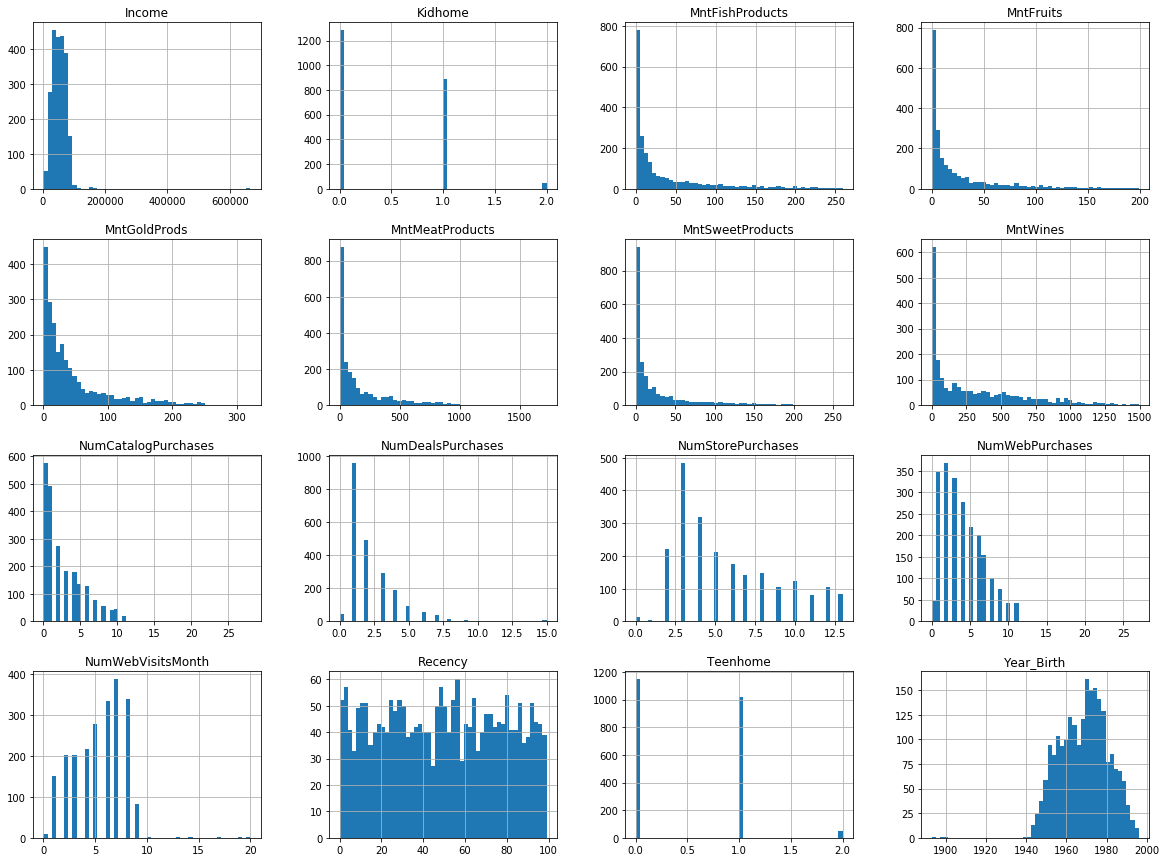

In [13]:
numerical_attributes.hist(bins=50, figsize = (20,15));


### 1.6.2 Categorical Attributes

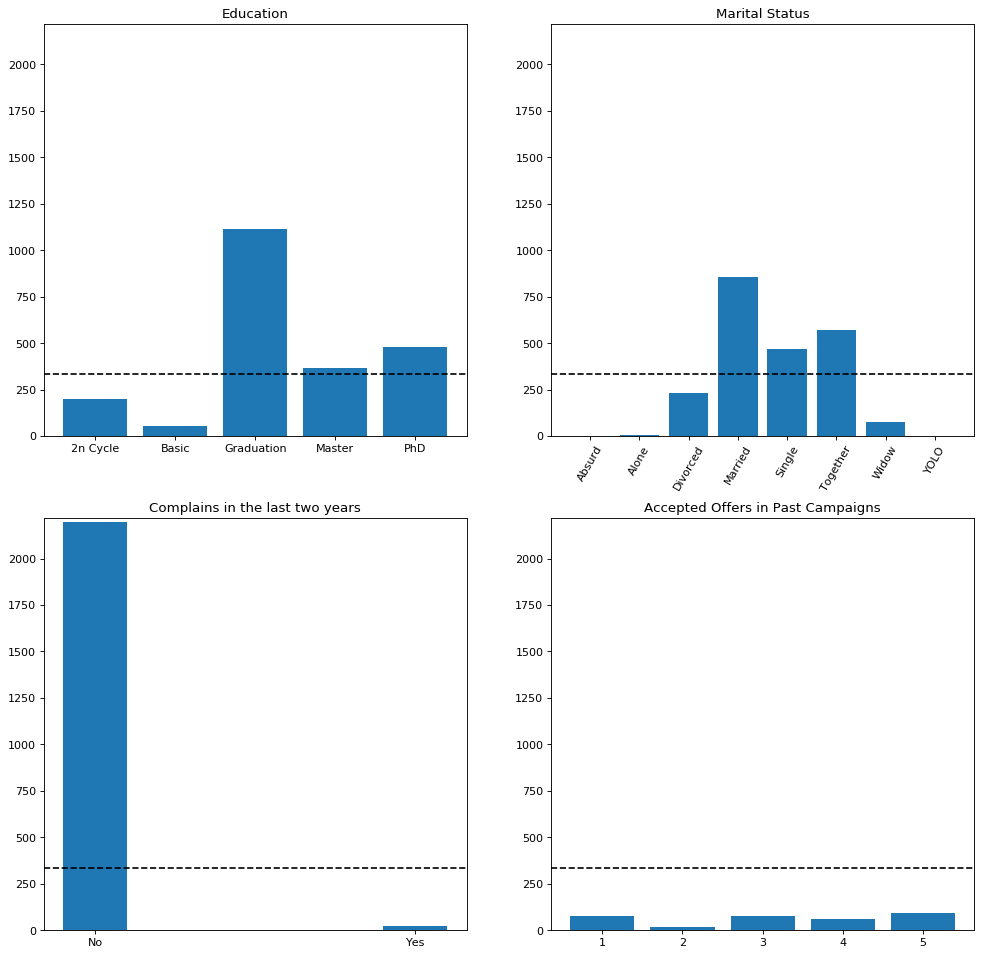

In [15]:
fig=plt.figure(figsize=(15,15), dpi= 80)

grid = GridSpec(2,2, hspace=0.2)

#Education
plt.subplot(grid[0,0])
cat_att_distribution(categorical_attributes, 'Education','Response', 'Education')

#Education
plt.subplot(grid[0,1])
cat_att_distribution(categorical_attributes, 'Marital_Status','Response', 'Marital Status', rot=60)

#Complain
plt.subplot(grid[1,0])
cat_att_distribution(categorical_attributes, 'Complain','Response', 'Complains in the last two years')

#Accepted Campaigns
cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
accepted_campaigns = {}

i = 1
for elem in cols:    
    aux = categorical_attributes[[elem, 'Response']].groupby(elem).sum().reset_index()
    accepted_campaigns[i] = aux.iloc[1,1]
    i+=1
    

accepted_campaigns = pd.DataFrame(accepted_campaigns.items())
accepted_campaigns.columns = ['Campaign_Number', 'Accepted']

plt.subplot(grid[1,1])
plt.bar(accepted_campaigns['Campaign_Number'],accepted_campaigns['Accepted'])
plt.ylim([0, 2216])
plt.axhline(y=333, linestyle='--', c='black')
plt.title('Accepted Offers in Past Campaigns');

# 2.0 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map 

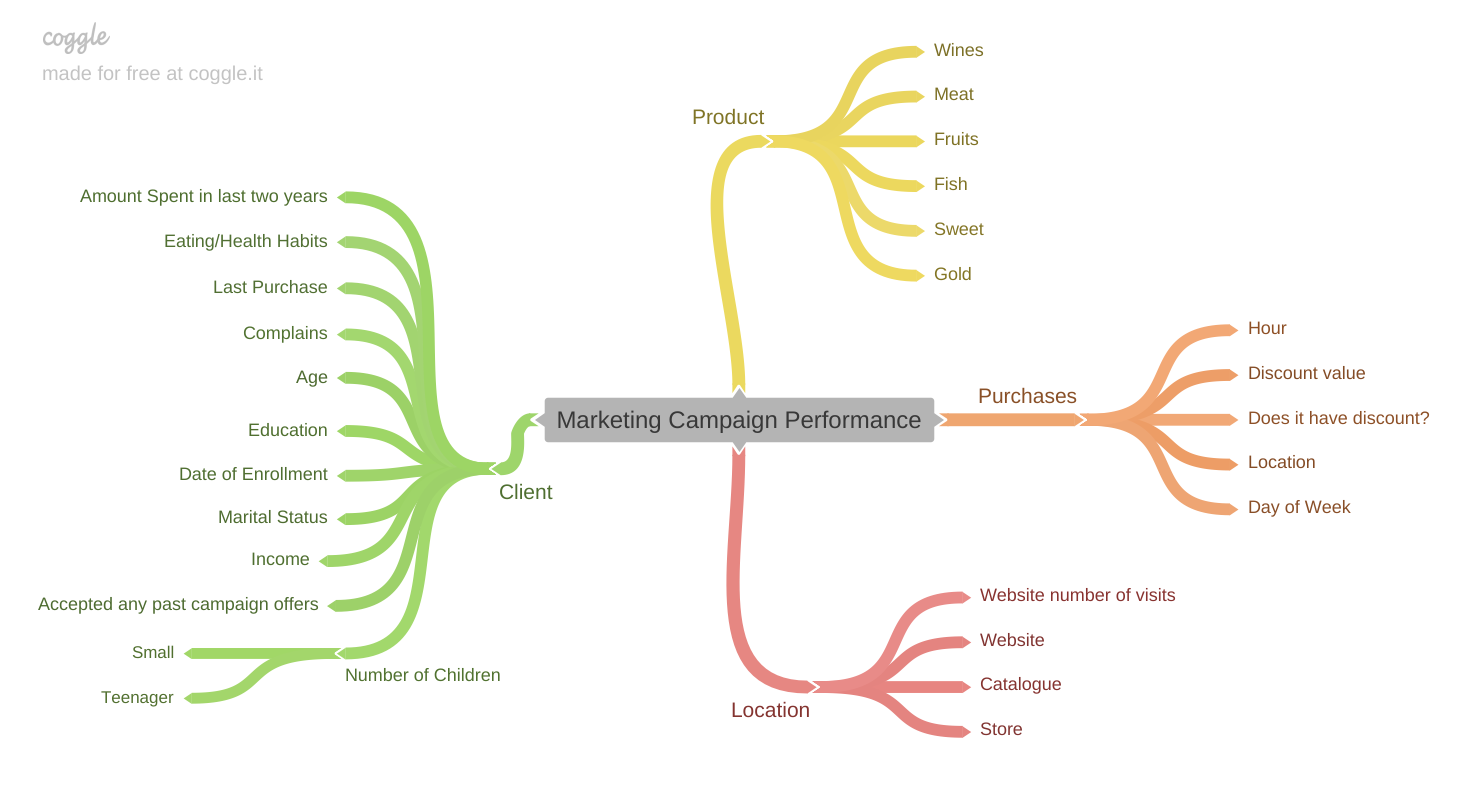

In [20]:
Image('img/Marketing_Campaign_Performance_mindmap.png')

## 2.2 Hypothesis Elaboration

### 2.2.1 Clients Hypothesis

**H1**:

### 2.2.2 Location Hypothesis

### 2.2.3 Products Hypothesis